#Football Player Prediction

In [3]:
#Standard-Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#Modellierung
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

In [5]:
# CSV-Dateien laden
wyscout_df = pd.read_csv("wyscout_players_final.csv")
kaggle_df = pd.read_csv("kaggle_players_final.csv")

# Zieldefinition:
kaggle_df["is_pro"] = 1
wyscout_df["is_pro"] = 1

# Kombinieren
combined_df = pd.concat([kaggle_df, wyscout_df], ignore_index=True)

combined_df.head()

,name,minutes_played,goals,assists,passes_total,passes_success,shots_total,shots_on_target,duels_total,duels_won,ball_losses,recoveries,is_pro
0,Max Aarons,2881.0,NaN,NaN,45.0,34.0,NaN,0.06,2.16,1.16,NaN,5.53,1
1,Yunis Abdelhamid,2983.0,NaN,NaN,47.0,38.7,NaN,0.18,1.87,1.39,NaN,6.77,1
2,Salis Abdul Samed,2462.0,NaN,NaN,61.0,55.9,NaN,0.18,2.01,1.24,NaN,8.76,1
3,Laurent Abergel,2956.0,NaN,NaN,49.8,40.7,NaN,0.21,3.57,2.23,NaN,8.87,1
4,Charles Abi,45.0,NaN,NaN,12.0,4.0,NaN,0.00,0.00,0.00,NaN,4.00,1


In [6]:
# Feature: Passquote
combined_df["pass_accuracy"] = (
    combined_df["passes_success"] / combined_df["passes_total"]
).round(2)

In [12]:
# Feature: Gesamteffektivität
combined_df["pass_accuracy"] = (
    combined_df["passes_success"] / combined_df["passes_total"].replace(0, np.nan)
).round(2)


combined_df["activity_score"] = (
    combined_df["passes_success"].fillna(0) +
    combined_df["duels_won"].fillna(0) +
    combined_df["recoveries"].fillna(0)
).round(2)

combined_df.head()

,name,minutes_played,goals,assists,passes_total,passes_success,shots_total,shots_on_target,duels_total,duels_won,ball_losses,recoveries,is_pro,pass_accuracy,activity_score
0,Max Aarons,2881.0,NaN,NaN,45.0,34.0,NaN,0.06,2.16,1.16,NaN,5.53,1,0.76,40.69
1,Yunis Abdelhamid,2983.0,NaN,NaN,47.0,38.7,NaN,0.18,1.87,1.39,NaN,6.77,1,0.82,46.86
2,Salis Abdul Samed,2462.0,NaN,NaN,61.0,55.9,NaN,0.18,2.01,1.24,NaN,8.76,1,0.92,65.90
3,Laurent Abergel,2956.0,NaN,NaN,49.8,40.7,NaN,0.21,3.57,2.23,NaN,8.87,1,0.82,51.80
4,Charles Abi,45.0,NaN,NaN,12.0,4.0,NaN,0.00,0.00,0.00,NaN,4.00,1,0.33,8.00


In [13]:
#Datenüberblick
combined_df.info()
combined_df.describe()
combined_df.isna().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5650 entries, 0 to 5649
Data columns (total 15 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             5650 non-null   object 
 1   minutes_played   5650 non-null   float64
 2   goals            40 non-null     float64
 3   assists          40 non-null     float64
 4   passes_total     5650 non-null   float64
 5   passes_success   5650 non-null   float64
 6   shots_total      40 non-null     float64
 7   shots_on_target  5650 non-null   float64
 8   duels_total      5650 non-null   float64
 9   duels_won        5650 non-null   float64
 10  ball_losses      40 non-null     float64
 11  recoveries       5650 non-null   float64
 12  is_pro           5650 non-null   int64  
 13  pass_accuracy    5615 non-null   float64
 14  activity_score   5650 non-null   float64
dtypes: float64(13), int64(1), object(1)
memory usage: 662.2+ KB


name                  0
minutes_played        0
goals              5610
assists            5610
passes_total          0
passes_success        0
shots_total        5610
shots_on_target       0
duels_total           0
duels_won             0
ball_losses        5610
recoveries            0
is_pro                0
pass_accuracy        35
activity_score        0
dtype: int64

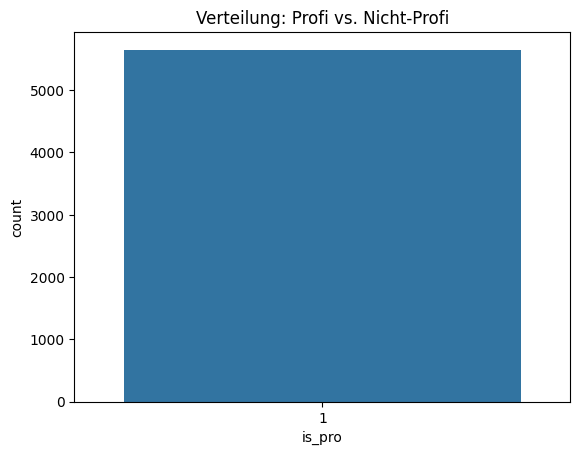

In [14]:
combined_df["is_pro"].value_counts(normalize=True)
sns.countplot(data=combined_df, x="is_pro")
plt.title("Verteilung: Profi vs. Nicht-Profi")
plt.show()


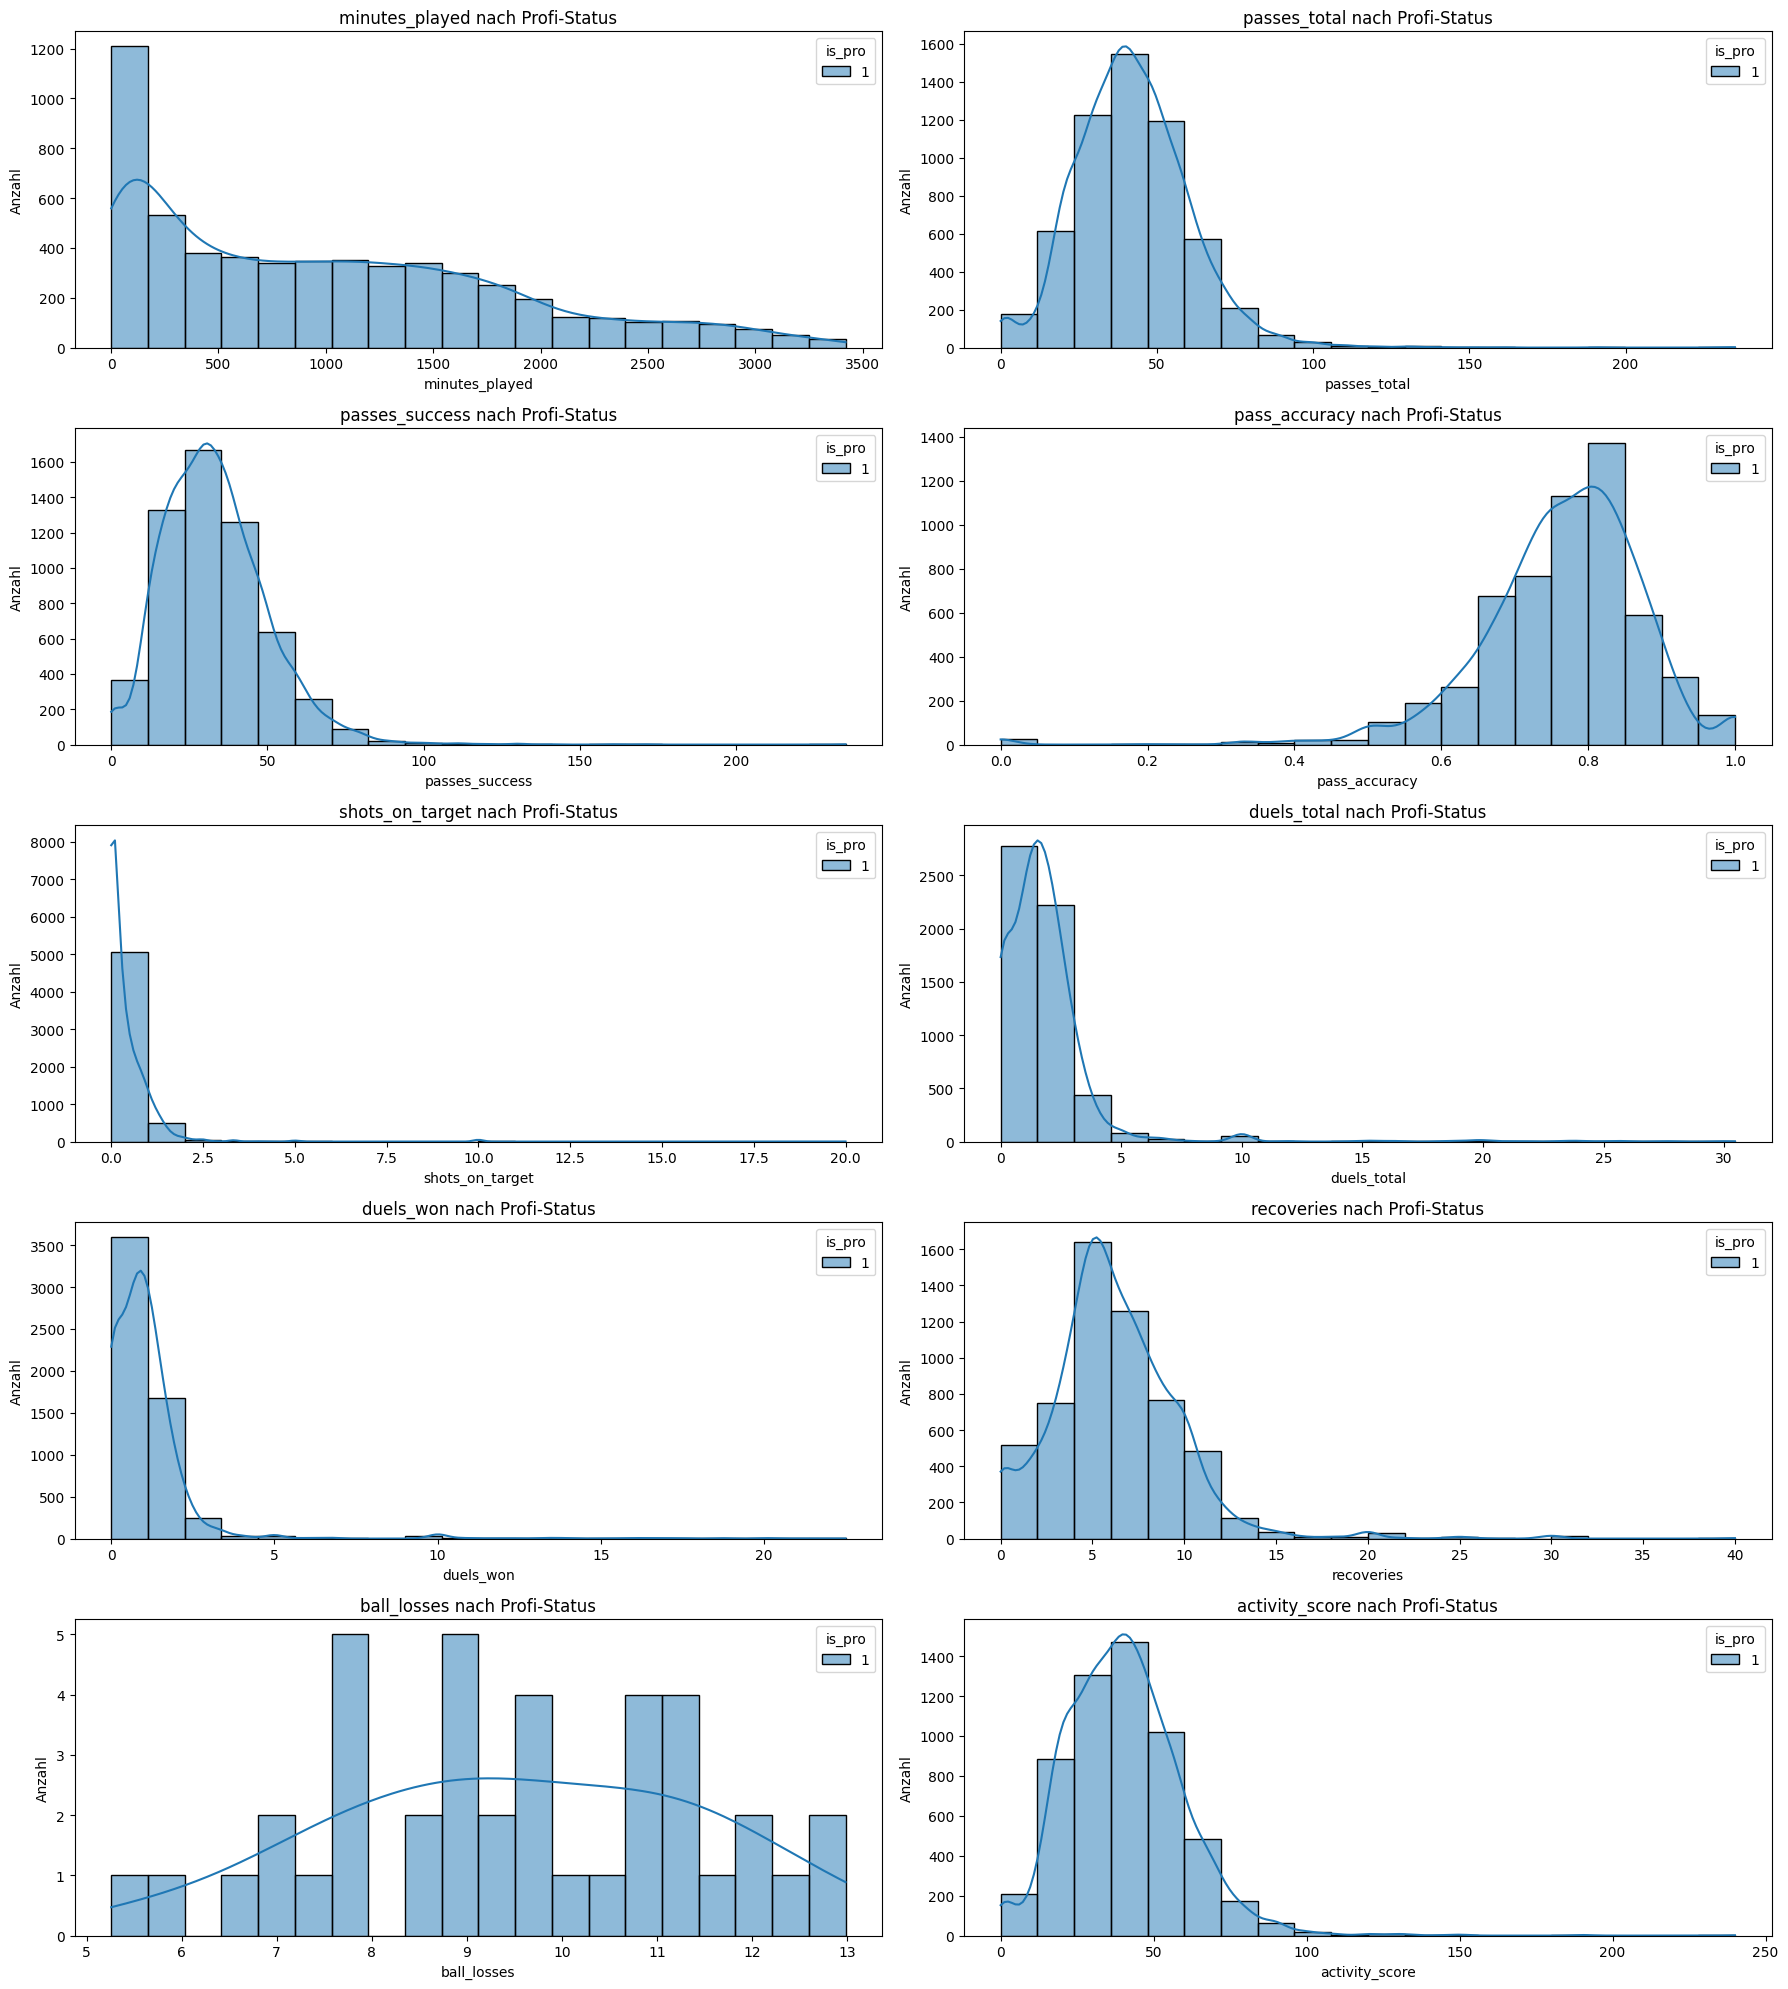

In [17]:
features = [
    "minutes_played",
    "passes_total",
    "passes_success",
    "pass_accuracy",
    "shots_on_target",
    "duels_total",
    "duels_won",
    "recoveries",
    "ball_losses",
    "activity_score"
]

# Zeichne alle Histogramme in einem Raster (z. B. 5x2)
plt.figure(figsize=(18, 20))
for i, feature in enumerate(features):
    plt.subplot(5, 2, i + 1)
    sns.histplot(data=combined_df, x=feature, hue="is_pro", kde=True, bins=20)
    plt.title(f"{feature} nach Profi-Status")
    plt.xlabel(feature)
    plt.ylabel("Anzahl")

plt.tight_layout()
plt.show()

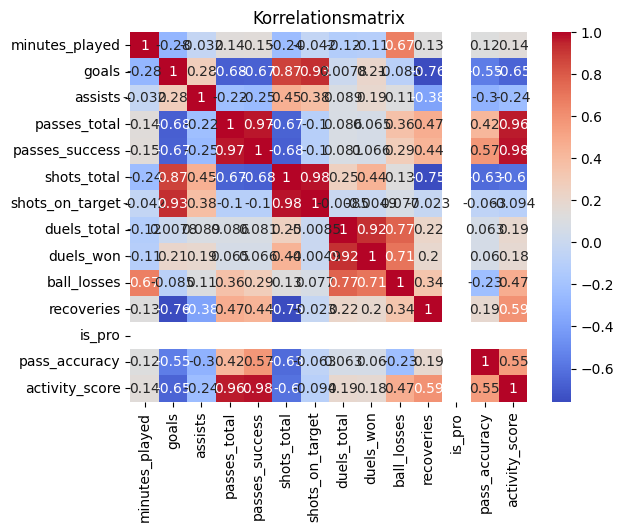

In [16]:
#Korrelationen analysieren

sns.heatmap(combined_df.corr(numeric_only=True), annot=True, cmap="coolwarm")
plt.title("Korrelationsmatrix")
plt.show()

In [21]:
# Entferne unrealistische Werte (z. B. extreme Pässe pro 90')
combined_df = combined_df[combined_df["passes_total"] <= 120]
combined_df = combined_df[combined_df["duels_total"] <= 60]

# Vorschau nach dem Filtern
combined_df.reset_index(drop=True, inplace=True)
combined_df.head()

,name,minutes_played,goals,assists,passes_total,passes_success,shots_total,shots_on_target,duels_total,duels_won,ball_losses,recoveries,is_pro,pass_accuracy,activity_score
0,Max Aarons,2881.0,NaN,NaN,45.0,34.0,NaN,0.06,2.16,1.16,NaN,5.53,1,0.76,40.69
1,Yunis Abdelhamid,2983.0,NaN,NaN,47.0,38.7,NaN,0.18,1.87,1.39,NaN,6.77,1,0.82,46.86
2,Salis Abdul Samed,2462.0,NaN,NaN,61.0,55.9,NaN,0.18,2.01,1.24,NaN,8.76,1,0.92,65.90
3,Laurent Abergel,2956.0,NaN,NaN,49.8,40.7,NaN,0.21,3.57,2.23,NaN,8.87,1,0.82,51.80
4,Dickson Abiama,726.0,NaN,NaN,17.2,11.1,NaN,0.49,1.73,0.86,NaN,4.81,1,0.65,16.77


⚠️  Überspringe ball_losses – hat zu wenig gültige Werte.


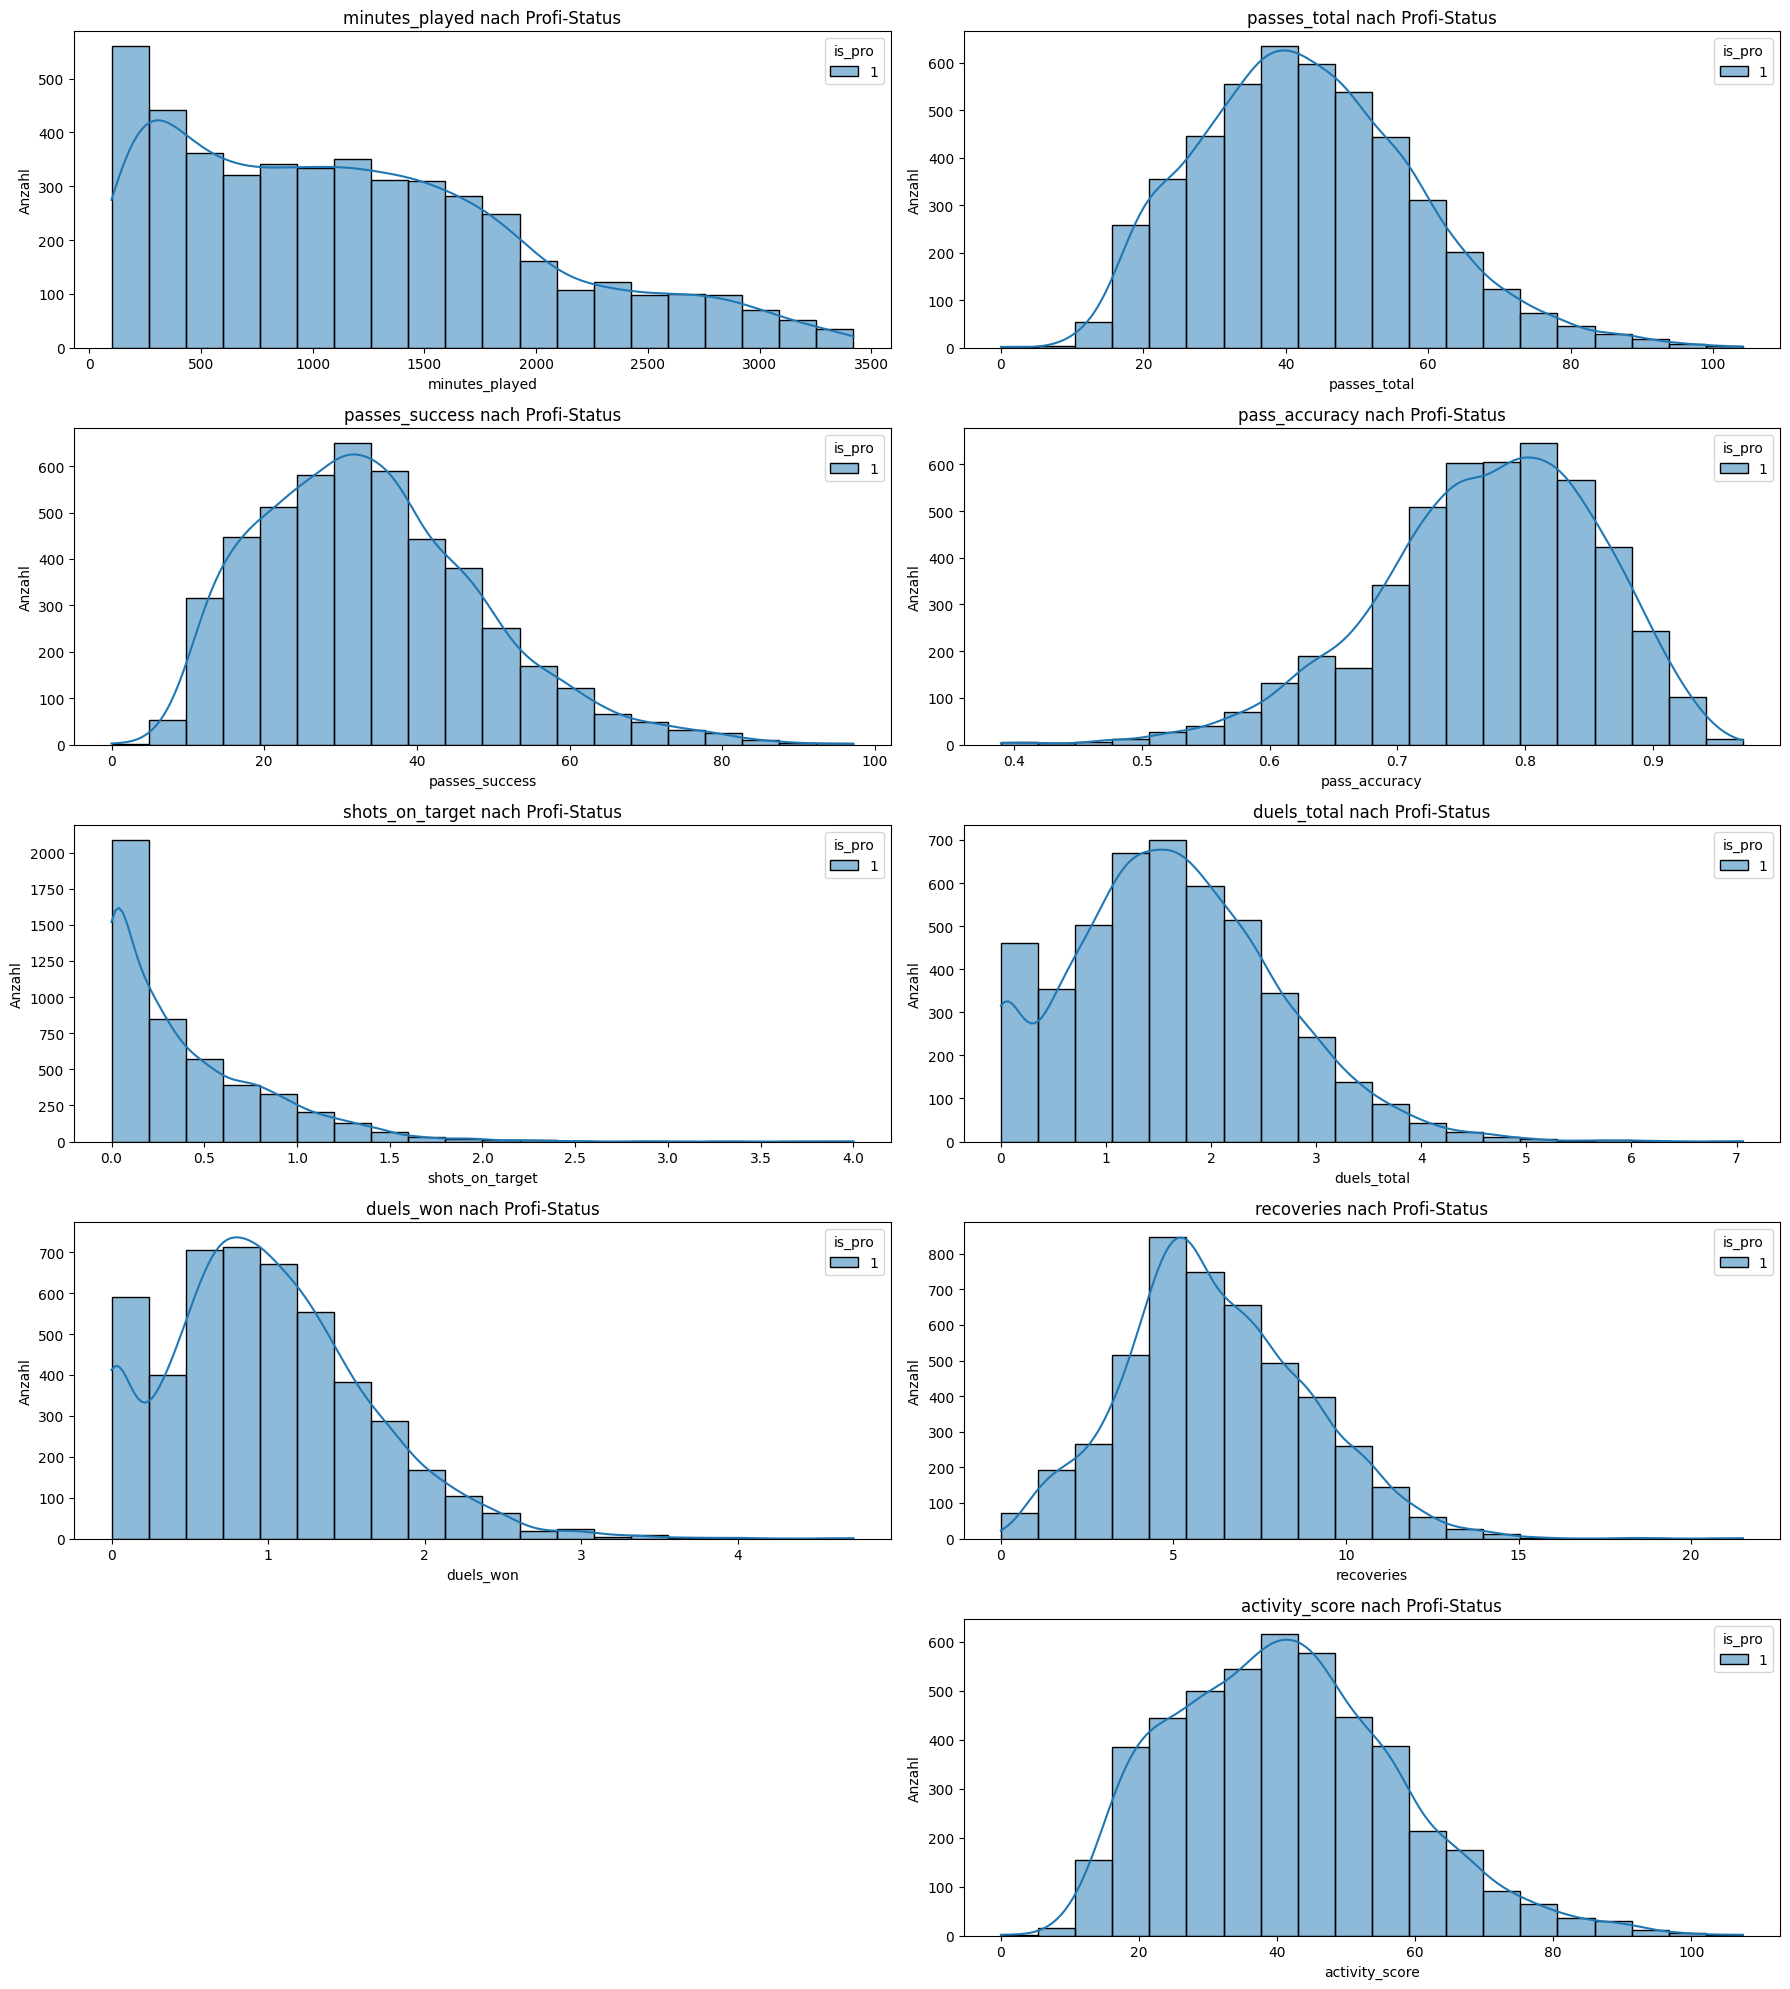

In [24]:
#Visualisierung nach Bereinigung
features = [
    "minutes_played",
    "passes_total",
    "passes_success",
    "pass_accuracy",
    "shots_on_target",
    "duels_total",
    "duels_won",
    "recoveries",
    "ball_losses",
    "activity_score"
]

plt.figure(figsize=(18, 20))
for i, feature in enumerate(features):
    if combined_df[feature].dropna().nunique() <= 1:
        print(f"⚠️  Überspringe {feature} – hat zu wenig gültige Werte.")
        continue
    plt.subplot(5, 2, i + 1)
    sns.histplot(data=combined_df, x=feature, hue="is_pro", kde=True, bins=20)
    plt.title(f"{feature} nach Profi-Status")
    plt.xlabel(feature)
    plt.ylabel("Anzahl")

plt.tight_layout()
plt.show()
